In [2]:
import pytorch_lightning as pl
import os
import csv
import rasterio

from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from pathlib import Path
from datetime import datetime

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.datasets as datasets
import dl_toolbox.utils as utils

from dl_toolbox.datasets import Raster, PretiledRaster


if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
else:
    data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    #data_root = Path(os.environ['TMPDIR'])
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'

# datasets params
data_path = data_root / 'DIGITANIE'
split_dir = home / f'dl_toolbox/dl_toolbox/datamodules'
train_split = (split_dir/'digitanie_toulouse.csv', [0,1,2,3,4,5])
unsup_train_split = pl_split = (split_dir/'digitanie_toulouse_big_1.csv', [0])
val_split = (split_dir/'digitanie_toulouse.csv', [6,7])
crop_size = 256
pl_crop_size = 10000
crop_step = 256
pl_crop_step = 10000
aug = 'd4_color-5'
unsup_aug = pl_aug = 'd4'
labels = 'mainFuseVege'
bands = [1,2,3]

ImportError: cannot import name 'Raster' from 'dl_toolbox.datasets' (/d/pfournie/dl_toolbox/dl_toolbox/datasets/__init__.py)

In [2]:
train_sets = []
for ds in datasets.datasets_from_csv(data_path, *train_split):
    train_sets.append(Raster(ds, crop_size, aug, bands, labels))
train_set = ConcatDataset(train_sets)

In [3]:
pl_sets = []
holes_bounds = []
for ds in train_sets:
    window = ds.raster.window
    tf = ds.raster_tf
    holes_bounds.append(rasterio.windows.bounds(window, tf))
for ds in datasets.datasets_from_csv(data_path, *pl_split):
    with rasterio.open(ds.image_path) as raster_img:
        dst_tf = raster_img.transform
    holes = [rasterio.windows.from_bounds(*b, dst_tf) for b in holes_bounds]
    pl_sets.append(
        PretiledRaster(
            crop_step=pl_crop_step,
            raster=ds,
            crop_size=pl_crop_size,
            aug=pl_aug,
            bands=bands,
            labels=labels,
            holes=holes
        )
    )
    for tile in pl_sets[-1].tiles:
        print(tile)
pl_set = ConcatDataset(pl_sets) 

Window(col_off=20000, row_off=20000, width=10000, height=10000) intersects with Window(col_off=25533.423475789605, row_off=28118.440661251545, width=2047.9516634423053, height=2050.9501285422593)
Window(col_off=20000, row_off=30000, width=10000, height=10000) intersects with Window(col_off=25532.423987422837, row_off=30165.392836326733, width=2047.9516634423053, height=2047.951663441956)
Window(col_off=30000, row_off=30000, width=10000, height=10000) intersects with Window(col_off=29534.37540783407, row_off=32166.368546532467, width=2046.9521750755375, height=2046.9521750751883)
Window(col_off=0, row_off=0, width=10000, height=10000)
Window(col_off=0, row_off=10000, width=10000, height=10000)
Window(col_off=0, row_off=20000, width=10000, height=10000)
Window(col_off=0, row_off=30000, width=10000, height=10000)
Window(col_off=0, row_off=40000, width=10000, height=10000)
Window(col_off=0, row_off=44062, width=10000, height=10000)
Window(col_off=10000, row_off=0, width=10000, height=10000

In [4]:
"""
Plusieurs obj : 
    - ne pas sampler le nodata
    - ne pas sampler dans des data de train
    - sampler des crops rotationnés
Plusieurs approches : 
    - un polygone définit la zone dans laquelle on sample
    - on définit proprement le nodata et on sample des masked arrays puis on filtre les holes
"""

'\nPlusieurs obj : \n    - ne pas sampler le nodata\n    - ne pas sampler dans des data de train\n    - sampler des crops rotationnés\nPlusieurs approches : \n    - un polygone définit la zone dans laquelle on sample\n    - on définit proprement le nodata et on sample des masked arrays puis on filtre les holes\n'

In [5]:
def shape_color(name, alpha):
    color = colors.to_rgba(name)
    facecolor = list(color)
    facecolor[-1] = alpha
    facecolor = tuple(facecolor)
    edgecolor = color
    return facecolor, edgecolor

def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

def intersect(window, holes):
    
    for hole in holes:
        try:
            inter = window.intersection(hole)
            return True
        except rasterio.errors.WindowError:
            pass
        
    return False

In [22]:
import fiona
import shapely
import rasterio
import torch
import pyproj
from rasterio import features
from fiona.transform import transform as f_transform
import numpy as np
from shapely import plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import PatchCollection
from copy import copy
from rasterio import plot as rioplt
from shapely import ops
import numpy.ma as ma
from dl_toolbox.utils import get_tiles
from dl_toolbox.utils import minmax
import torchvision.transforms.functional as F 

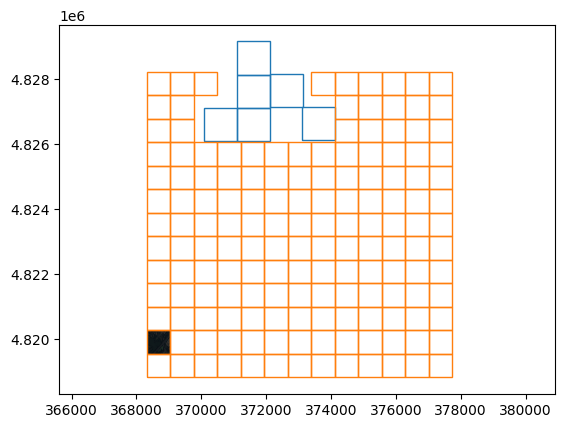

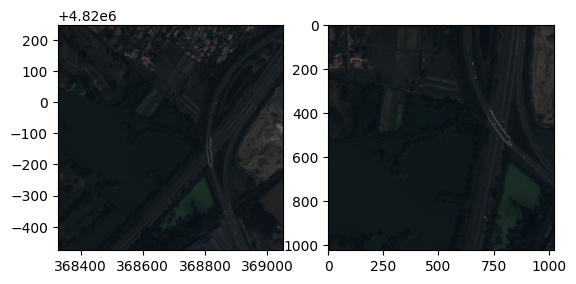

In [29]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
f0, e0 = shape_color("C0", 0)
f1, e1 = shape_color("C1", 0)

with rasterio.open('/data/DIGITANIE/Toulouse/Toulouse.tif', 'r+') as src:
    bounds = src.bounds
    tf = src.transform
    
    poly = shapely.Polygon(generate_polygon(bounds))
    patch = plotting.patch_from_polygon(poly, facecolor=f0, edgecolor=e0)
    #ax.add_patch(copy(patch))
    
    #src.nodata = 0
    #window = rasterio.windows.Window(0, 0, 4056, 4056)
    #bounds = rasterio.windows.bounds(window, tf)
    #poly = shapely.Polygon(generate_polygon(bounds))
    #patch = plotting.patch_from_polygon(poly, facecolor=f, edgecolor=e)
    #ax.add_patch(copy(patch))
    #mask = src.read_masks(window=window, indexes=1)
    #img = src.read(window=window, indexes=[1,2,3], masked=False)

raster = datasets.Digitanie(
    image_path='/data/DIGITANIE/Toulouse/Toulouse.tif',
    label_path=None,
    window=rasterio.windows.Window(20000, 30000, 20000, 20000)
)
with rasterio.open(raster.image_path) as raster_img:
    raster_tf = raster_img.transform
    
windows_to_avoid = []
for ds in train_sets:
    window = ds.raster.window
    bounds = rasterio.windows.bounds(window, ds.raster_tf)
    windows_to_avoid.append(rasterio.windows.from_bounds(*bounds, raster_tf))
    poly = shapely.Polygon(generate_polygon(bounds))
    patch = plotting.patch_from_polygon(poly, facecolor=f0, edgecolor=e0)
    ax.add_patch(copy(patch))

tiles = []
for tile in get_tiles(
    nols=raster.window.width, 
    nrows=raster.window.height, 
    size=int(np.ceil(np.sqrt(2) * 1024)), 
    step=int(np.ceil(np.sqrt(2) * 1024)),
    row_offset=raster.window.row_off, 
    col_offset=raster.window.col_off,
    cover_all=False
):
    if not intersect(tile, windows_to_avoid):
        tiles.append(tile)
        
for tile in tiles:
    bounds = rasterio.windows.bounds(tile, raster_tf)
    poly = shapely.Polygon(generate_polygon(bounds))
    patch = plotting.patch_from_polygon(poly, facecolor=f1, edgecolor=e1)
    ax.add_patch(copy(patch))

i=0
while True:
    crop_tile = np.random.choice(tiles)
    crop_tf = rasterio.windows.transform(crop_tile, transform=raster_tf)
    with rasterio.open('/data/DIGITANIE/Toulouse/Toulouse.tif', 'r+') as file:
        image = file.read(window=crop_tile, out_dtype=np.float32, indexes=bands)
    mask0 = np.isclose(image, np.array([0., 0., 0.]).reshape(3, 1, 1)).all(axis=0)
    mask1 = np.isclose(image, np.array([0.0195023, 0.0336404, 0.0569544]).reshape(3, 1, 1)).all(axis=0)
    if not(mask0.any() or mask1.any()):
        bands_idxs = np.array(bands).astype(int) - 1
        image = minmax(image, raster.mins[bands_idxs], raster.maxs[bands_idxs])
        rioplt.show(image, ax=ax, transform=crop_tf)
        break
    if i==50:
        break
    i += 1
    print(i)
    
    
ax.axis('equal')
ax.autoscale_view()

fig, (ax1, ax2) = plt.subplots(1, 2)
rioplt.show(image, ax=ax1, transform=crop_tf)
image = torch.from_numpy(image).float().contiguous()
image = F.rotate(image, angle=30)
image = F.center_crop(image, output_size=1024)
ax2.imshow(image.numpy().transpose(1,2,0))

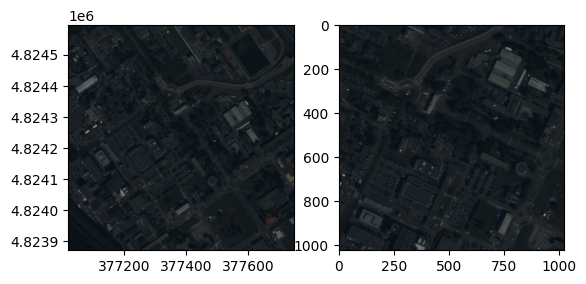

In [24]:
def crop_from_window(window, crop_size):
    
    cx = window.col_off + np.random.randint(0, window.width - crop_size + 1)
    cy = window.row_off + np.random.randint(0, window.height - crop_size + 1)
    crop = Window(cx, cy, crop_size, crop_size)
    
    return crop

def intersect(window, holes):
    
    for hole in holes:
        try:
            inter = window.intersection(hole)
            return True
        except rasterio.errors.WindowError:
            pass
        
    return False

def crop_avoiding_holes(window, crop_size, holes):
    
    while True:
        cx = window.col_off + np.random.randint(0, window.width - crop_size + 1)
        cy = window.row_off + np.random.randint(0, window.height - crop_size + 1)
        crop = Window(cx, cy, crop_size, crop_size)
        if not intersect(crop, holes) : return crop

(371092.85258633044, 4828135.49076299)
(371292.8478659635, 4827635.502563908)


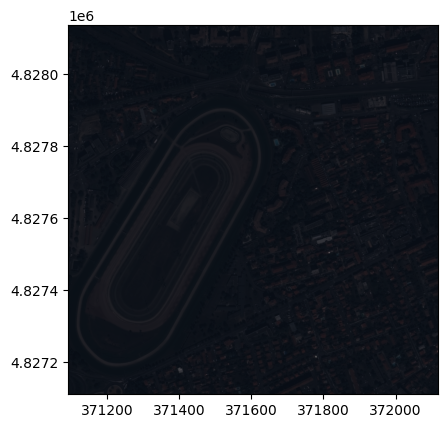

In [47]:
from rasterio.transform import Affine

img_path = '/data/DIGITANIE/Toulouse/Toulouse_EPSG32631_0.tif'
with rasterio.open(img_path, 'r') as f:
    img = f.read(indexes=[1,2,3])
    img_tf = f.transform

w = Window(0, 0, 200, 200)
wtf = tf * Affine.translation(400, 1000) * Affine.rotation(30.)
print(tf * (0,0))
print(wtf * (0, 0))
minx, miny, maxx, maxy = rasterio.windows.bounds(w, transform=wtf)

#with rasterio.open('/data/DIGITANIE/Toulouse/COS9/Toulouse_0.tif') as f:
#    
#    
#    
#    window = rasterio.windows.from_bounds(
#        minx, miny, maxx, maxy,
#        transform=tf
#    )
#    crop = f.read(window)
#
fig, ax = plt.subplots(1, 1)
#f, e = shape_color("C0", 0)
#zone_patch = plotting.patch_from_polygon(zone, facecolor=f, edgecolor=e)
#ax.add_patch(copy(zone_patch))
rioplt.show(img, ax=ax, transform=img_tf)
#rioplt.show(crop, ax=ax, transform=tf, cmap='gray')
ax.autoscale_view()

In [37]:
w = Window(0, 0, 200, 200)
tf = img46.transform * Affine.translation(100, 200) * Affine.rotation(30.)


minx, miny, maxx, maxy = rasterio.windows.bounds(w, transform=tf)
print(minx, miny, maxx, maxy)
new_window = rasterio.windows.from_bounds(
    minx, miny, maxx, maxy,
    transform=img46.transform
)


358126.640592619 4842685.174479261 358809.65329451126 4842868.187181153


In [ ]:
w = Window(0,0,10000,10000)
holes = [Window(0,0,3000,3000), Window(5000,6000,3000,3000)]
crop = crop_avoiding_holes(w, 1000, holes)
crop_img = img46.read(window=crop, out_dtype=np.uint8)[[0]]

In [ ]:
zone = np.random.choice(intersections)
mask46 = shapely.geometry.MultiPolygon(mask46polys)
ds = PolyRaster(
    raster_img_path=img_path_46,
    raster_label_path=label_path_46,
    polygon=zone,
    crop_size=512,
    labels='base',
    raster_mask_poly=mask46
)

item = ds[0]
print(item['image'][0].shape)

fig, ax = plt.subplots(1, 1)
f, e = shape_color("C0", 0)
zone_patch = plotting.patch_from_polygon(zone, facecolor=f, edgecolor=e)
ax.add_patch(copy(zone_patch))
rioplt.show(item['label'].numpy(), ax=ax, transform=item['tf_label'], cmap='viridis')
rioplt.show(item['image'][0].numpy(), ax=ax, transform=item['tf_image'], cmap='gray')
ax.autoscale_view()


In [ ]:
output_transform = Affine.translation(dst_w, dst_n) * Affine.scale(res[0], -res[1])

In [ ]:
train_zone = intersections[16] # raster coords
train_zone_bounds = train_zone.bounds
# raster pixel coords
tile = rasterio.windows.from_bounds(
    *train_zone_bounds, 
    transform=raster.transform
).round_offsets().round_lengths()
tile_poly = shapely.Polygon(generate_polygon(train_zone_bounds))
tile_patch = plotting.patch_from_polygon(tile_poly, facecolor=facecolor, edgecolor=edgecolor)

area = 0
crop_size=512
while area <= 0 or area >= 1:
    cx = tile.col_off + np.random.randint(0, tile.width - crop_size + 1)
    cy = tile.row_off + np.random.randint(0, tile.height - crop_size + 1)
    # raster pixel coords
    crop = rasterio.windows.Window(cx, cy, crop_size, crop_size)
    left, bottom, right, top = rasterio.windows.bounds(crop, transform=raster.transform)
    crop_poly = shapely.Polygon(generate_polygon((left, bottom, right, top)))
    crop_patch = plotting.patch_from_polygon(crop_poly, facecolor=facecolor, edgecolor=edgecolor)
    intersection = shapely.intersection(crop_poly, train_zone)
    area = shapely.area(intersection) / shapely.area(crop_poly)
print(area)
train_zone_patch = plotting.patch_from_polygon(train_zone, facecolor=facecolor, edgecolor=edgecolor)
crop_img, crop_transform = rasterio.mask.mask(raster, shapes=[intersection], crop=True)


fig3, ax3 = plt.subplots()
ax3.add_patch(tile_patch)
ax3.add_patch(crop_patch)
ax3.add_patch(train_zone_patch)
rioplt.show(crop_img, ax=ax3, transform=crop_transform)
ax3.autoscale_view()